In [4]:
!pip install tensorflow keras
import zipfile
import os

# Extract the dataset
zip_path = '/content/summer2winter.zip'
extract_path = '/content/sample_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [8]:
import tensorflow as tf
import os

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 1
BUFFER_SIZE = 1000

# Function to load and preprocess images
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Create a dataset loader
def create_dataset(dir_path):
    dataset = tf.data.Dataset.list_files(os.path.join(dir_path, '*.jpg'))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset

# Load datasets using the updated paths
summer_path = '/content/sample_data/trainA'
winter_path = '/content/sample_data/trainB'

# Ensure directories exist and are not empty
assert len(os.listdir(summer_path)) > 0, f"No images found in {summer_path}"
assert len(os.listdir(winter_path)) > 0, f"No images found in {winter_path}"

summer_dataset = create_dataset(summer_path)
winter_dataset = create_dataset(winter_path)


In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Define the generator model
def build_generator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    # Downsample
    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(256, 4, strides=2, padding='same', activation='relu'),
    ]

    # Upsample
    up_stack = [
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh'),
    ]

    x = inputs
    for down in down_stack:
        x = down(x)

    for up in up_stack:
        x = up(x)

    return Model(inputs=inputs, outputs=x)

# Define the discriminator model
def build_discriminator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return Model(inputs=inputs, outputs=x)

# Build models
generator_g = build_generator()  # Generator G: summer -> winter
generator_f = build_generator()  # Generator F: winter -> summer
discriminator_x = build_discriminator()  # Discriminator X: distinguishes real summer images
discriminator_y = build_discriminator()  # Discriminator Y: distinguishes real winter images


In [12]:
# Loss function for evaluating adversarial loss
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Cycle consistency loss
def cycle_loss(real_image, cycled_image, lambda_cycle=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss

# Identity loss
def identity_loss(real_image, same_image, lambda_identity=10):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_identity * 0.5 * loss

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training step function
@tf.function
def train_step(real_x, real_y):
    # Persistent gradient tape
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates summer (real_x) to winter (fake_y)
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates winter (real_y) to summer (fake_x)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Same images for identity loss
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate the losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

# Training loop
def train(dataset_summer, dataset_winter, epochs):
    for epoch in range(epochs):
        for real_summer, real_winter in tf.data.Dataset.zip((dataset_summer, dataset_winter)):
            train_step(real_summer, real_winter)
        print(f'Epoch {epoch+1}/{epochs} completed')

# Train the model
train(summer_dataset, winter_dataset, epochs=10)


KeyboardInterrupt: 

Summer to Winter:


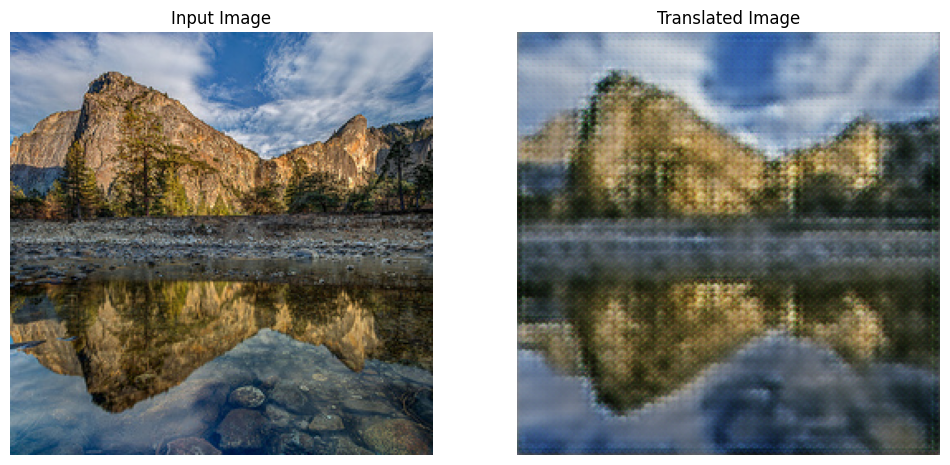

Winter to Summer:


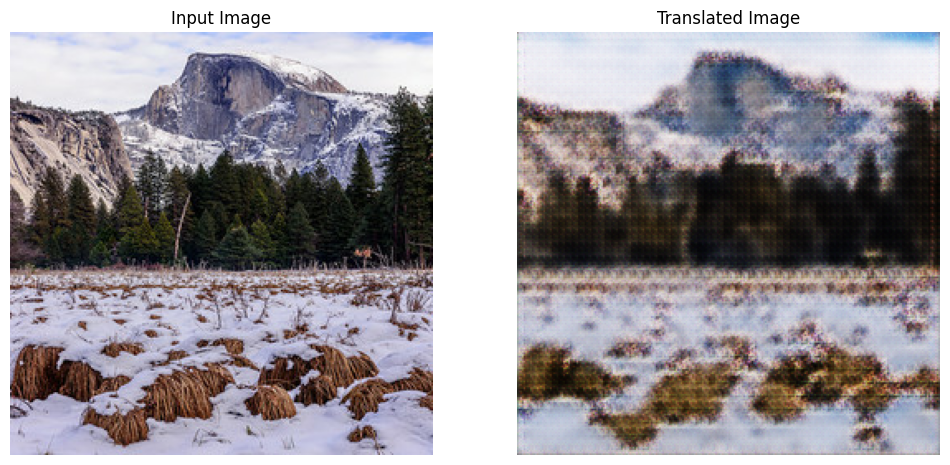

In [11]:
# Function to generate images
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Translated Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5) + 0.5)
        plt.axis('off')
    plt.show()

# Test the model on a sample image
sample_summer_image = next(iter(summer_dataset))
sample_winter_image = next(iter(winter_dataset))

print("Summer to Winter:")
generate_images(generator_g, sample_summer_image)

print("Winter to Summer:")
generate_images(generator_f, sample_winter_image)
